## **Install dependencies**

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
repsol_path = '/content/repsol-ml4md'
repsol_src_path = '/content/repsol-ml4md/src'
repsol_data_path = '/content/repsol-ml4md/data'

# Make sure to adapt the following line
your_workshop_path = '/content/drive/My Drive/Colab Notebooks/repsol-ml4md/'
os.symlink(f'{your_workshop_path}case_study', repsol_path)

Mounted at /content/drive


In [ ]:
sys.path.insert(0, repsol_src_path)
sys.path.insert(0, repsol_data_path)
repsol_path = '/content/repsol-ml4md'
sys.path.insert(0, repsol_path)

In [ ]:
%pip install rdkit-pypi
%pip install mordred
%pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
%pip install ml-collections
%pip install gpflow
%pip install guacamol==0.5.2
%pip install  cclib==1.7.1

## **Efficient Search for Molecules Maximizing Anti-Haze Properties**

In this case study, we will apply our acquired knowledge to a real-world scenario. The objective is to utilize available literature data on the *anti-haze* value of certain molecules to guide our search for molecules that optimize this property.

The notebook is divided into two parts:

1. Training and evaluating a probabilistic model for anti-haze prediction using existing labeled data from the literature.

2. Utilizing the aforementioned model in conjunction with a genetic algorithm to generate molecules with promising anti-haze predictions.

**Note:** due to time constraints, this notebook does not delve into the details of the code. Its purpose is purely illustrative. However, all the code is available!

Let's begin by loading all the necessary packages.



In [ ]:
import numpy as np
import pandas as pd

import rdkit
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem, Draw

from config import data_dir, name
from src.evaluator import MolEvaluator
from src.prob_model_evaluator import ModelEvaluator
from src.utils.datasets import load_task

from src.models.ngb import NGB
from src.models.gpr import GPr

from src.evomol import run_model

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams['lines.markersize'] = 7

Masking 0 feature dims for ['morgan']


## **Training a Probabilistic Model for Anti-Haze Prediction**

In this section, we will train a Gaussian Process Regression model using the Tanimoto kernel and Morgan Fingerprints as features to predict the anti-haze value. By now, you have learned how to:

- Compute Morgan Fingerprints for a given molecule.
- Fit a Gaussian Process Regression model to generate probabilistic forecasts for a specific property.
- Evaluate the accuracy of these forecasts.

The code to reproduce these steps is readily available and well-organized. Since you are already familiar with each of these steps, we will not delve into the details of the code.

To begin, let's load the anti-haze data and the corresponding Morgan fingerprints.


In [ ]:
feature_set = ["morgan"]
X, X_names, y, smis = load_task(data_dir, name, feature_set, mask_inputs=True)

df = pd.DataFrame(X)
df.columns = X_names
df["anti-haze"] = y

Masking 0 feature dims for ['morgan']


In [ ]:
X.shape

(68, 431)


In this section, our target property will be the anti-haze value at a concentration of 0.2. We have a dataset of 68 molecules with known anti-haze values. Let's take a look at its distribution in the dataset.

<Axes: xlabel='anti-haze', ylabel='Count'>

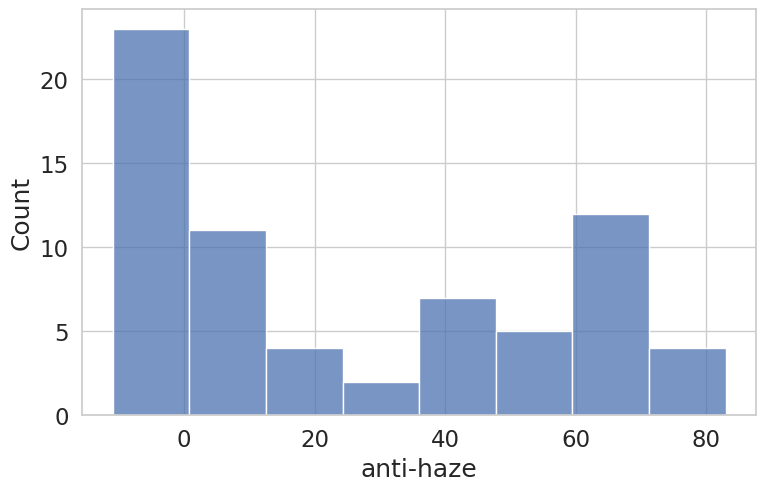

In [ ]:
sns.histplot(x=df["anti-haze"] , data=df)

Now, we will proceed to train and evaluate the model. The `evaluate_hold_out` function essentially replicates the hold-out validation process that we learned in session 1 multiple times. Its purpose is to provide us with the mean and standard deviation of the out-of-sample estimates of several performance metrics.

In [ ]:
model = GPr(kernel='Tanimoto')
feature_set = ["morgan"]
neval = ModelEvaluator(data_dir, name, feature_set, model)

m, a, b = neval.evaluate_hold_out(n_repeats=10)

Masking 0 feature dims for ['morgan']


As performance metrics for point forecasts, we will utilize the coefficient of determination ($R^2$) and the mean absolute error.

To evaluate the calibration of the forecasts, we will employ the Maximum Miss-Calibration (MMC) and the Absolute Miss-Calibration Area (AMC) metrics.

In [ ]:
m

,R^2,MAE,MMC,AMC
mean,0.500157,16.624872,0.149275,0.074365
50%,0.556860,16.057565,0.140097,0.059894
std,0.158386,2.635544,0.064148,0.043625


We can also visualize the calibration plot to further analyze the performance of our model.

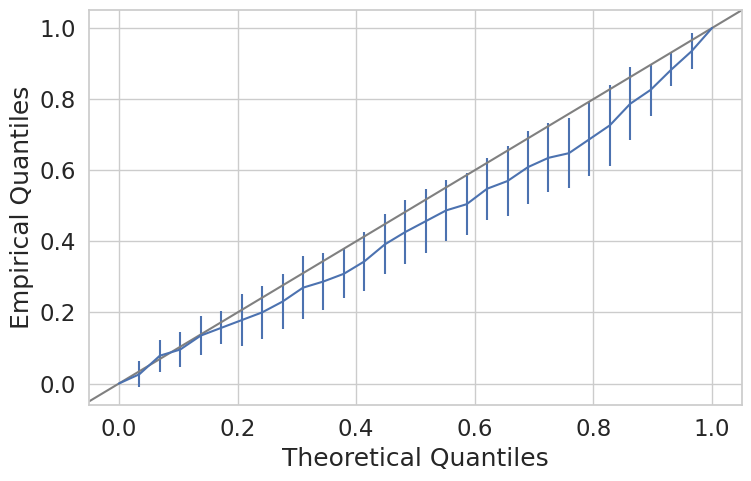

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.75,0.75]) # axis starts at 0.1, 0.1
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Empirical Quantiles")
ax.errorbar(x = a.loc["mean"].squeeze(), 
             y = b.loc["mean"].squeeze(), yerr= b.loc["std"].squeeze())
ax.axline([0, 0], [1,1], c='gray')

In conclusion, the model appears to be well-calibrated based on the calibration plot. However, the performance is not particularly strong, as evidenced by the $R^2$ value of 0.5.

## **Using Genetic Algorithms to Generate Molecules Optimizing Anti-Haze**

Now, we will integrate the previous probabilistic model with a genetic algorithm called EvoMol. The objective is to efficiently explore the chemical space and identify molecules with promising anti-haze values.

To achieve this, we need to implement a class with a method called `evaluate_individual()`. This method takes the SMILES representation of a molecule as input and returns a numerical value that needs to be maximized. This class should be included in the `evaluation.py` file of EvoMol.

We have already implemented this function. The quantity we want to optimize is known as the Upper Confidence Bound (UCB), commonly used in Bayesian Optimization. For a molecule represented by features $X$, UCB is defined as:

$$
\text{UCB}(X) = \widehat{\mu}(X) + \beta \cdot \widehat{\sigma}(X)
$$

Here, $\widehat{\mu}(X)$ represents the predictive mean, and $\widehat{\sigma}(X)$ represents the predictive standard deviation. The UCB metric balances the exploration-exploitation trade-off. It seeks molecules with high predictive mean while also considering molecules where model uncertainty (measured by the predictive standard deviation) is high. The parameter $\beta$ controls the exploration-exploitation trade-off.



In the next code snippet, we execute EvoMol for 100 iterations, commencing with the initial structure shown below.

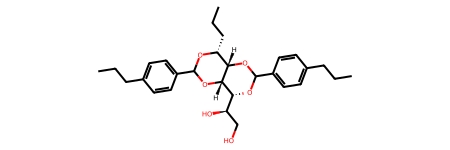

In [ ]:
smi = 'CCCc1ccc(C2O[C@@H]3[C@@H](OC(c4ccc(CCC)cc4)O[C@@H]3[C@H](O)CO)[C@@H](CCC)O2)cc1'
Chem.MolFromSmiles(smi)
#core = 'OC[C@H]1OCO[C@H]2COCO[C@H]21'

In [ ]:
run_model({
    "action_space_parameters":{
        "atoms": "C,N,O,S,Cl,Br"
    },
    "obj_function": "anti-haze",
    "optimization_parameters": {
        "max_steps": 100,
        "mutable_init_pop": False
    },
    "io_parameters": {
        "smiles_list_init" : [smi],
        "model_path": "results/test_antihaze5"
    },
})

The results are automatically saved in the `partial_results` folder. Now, let's examine the top 9 performing generated molecules.

In [ ]:
gen = pd.read_csv("results/test_antihaze5/pop.csv")
gen.head()

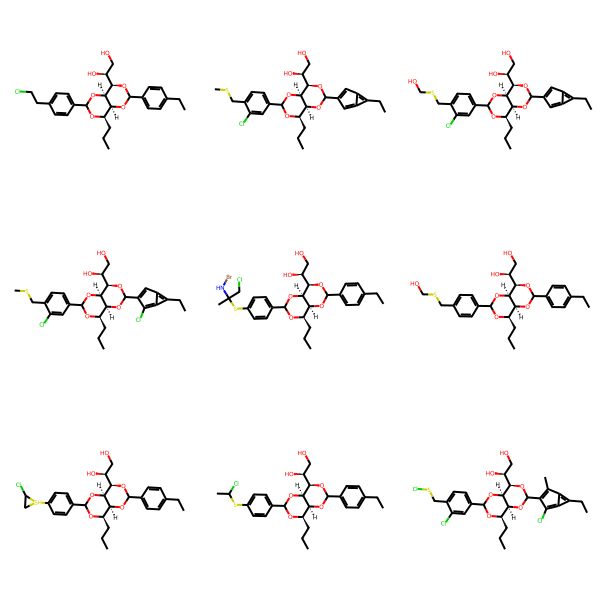

In [ ]:
smis = gen.sort_values(by="anti-haze", ascending=False)["smiles"].iloc[1:10]
ms = [Chem.MolFromSmiles(smi) for smi in smis]
Draw.MolsToGridImage(ms, molsPerRow=3,subImgSize=(200,200))    

# **Your turn**

Now, you have the flexibility to experiment with EvoMol's hyperparameters and the initial structure to generate additional molecules. Feel free to adjust these parameters to explore different possibilities.